In [2]:
# import required modules
%cd /home/gridsan/lchan/git-remotes/polychrom_analysis
import os
import sys
from pathlib import Path
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import matplotlib.colors as colors
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import polychrom
from polychrom.hdf5_format import list_URIs, load_URI, load_hdf5_file

from post_processing.visualization import *
from post_processing.analysis import *
from post_processing.compscores import *
from post_processing.msd import *

import random
import csv
import math
from scipy.stats import rv_continuous

import nglutils as ngu
import nglview as nv

/home/gridsan/lchan/git-remotes/polychrom_analysis


In [3]:
# overwritten methods
# overwrite method for parameter defaults
start_i = 0
end_i = 1109
def extract(path, start=start_i, every_other=1, end=end_i): # put here to modify start/ends. run before previous
    """Extract independent snapshots from a single simulation.

    Parameters
    ----------
    path : str
        path to simulation directory
    start : int
        block number to start extracting files from
    every_other : int
        skip this number of blocks in between snapshots (should be large enough
        so that snapshots are decorrelated)
    end : int
        last block to include in trajectory.
    """
    try:
        confs = list_URIs(path)
        if end:
            uris = confs[start:end:every_other]
        else:
            uris = confs[start::every_other]
    except:
        raise Exception("Exception! Something went wrong")
        uris = []
    return uris
def extract_conformations(basepath, ncores=24, chain=True, **kwargs):
    """Extract conformations from multiple simulation replicates to be included in
    ensemble-averaged observables.

    Parameters
    ----------
    basepath : str or Path
        parent directory where each subdirectory is a simulation replicate for one set of parameters
    ncores : int
        number of cores available for parallelization
    chain : bool
        whether to aggregate conformations from multiple simulations into one list.
        Defaults to True.

    Returns
    -------
    conformations : list
        If chain is True, list of hdf5 filenames containing polymer conformations.
        If chain is False, list of lists, where each sublist is from a separate simulation run.
    """
    basepath = Path(basepath)
    rundirs = [f for f in basepath.iterdir() if f.is_dir()]
    runs = len(rundirs)
    extract_func = partial(extract, **kwargs)
    with mp.Pool(ncores) as p:
        confs = p.map(extract_func, rundirs)
    if chain:
        conformations = list(itertools.chain.from_iterable(confs))
        print(f"Number of simulations in directory: {runs}")
        print(f"Number of conformations extracted: {len(conformations)}")
        return conformations, runs
    else:
        return confs, runs
def extract_hot_cold(simdir, D, start=1, every_other=11, copy = 1):
    """Load conformations from a simulation trajectory stored in the hdf5 files in simdir
    and store in two matrices, one for the `A` type monomers, and one for the `B` monomers.

    Parameters
    ----------
    simdir : str or Path
        path to simulation directory containing .h5 files
    D : np.ndarray
        array of monomer diffusion coefficients.
        Assumes there are only 2 values: D.min() and D.max().
    start : int
        which time block to start loading conformations from
    every_other : int
        skip every_other time steps when loading conformations
    copy : int
        the specific chain to visualize, starts from 0 to 199

    Returns
    -------
    Xhot : array_like (num_t, N_A, 3)
        x, y, z positions of all N_A active (hot) monomers over time
    Xcold : array-like (num_t, N_B, 3)
        x, y, z positions of all N_B inactive (cold) monomers over time

    """
    X = []
    N = len(D)
    data = list_URIs(simdir)
    if start == 0:
        starting_pos = load_hdf5_file(Path(simdir) / "starting_conformation_0.h5")[
            "pos"
        ]
        X.append(starting_pos)
    for conformation in data[start::every_other]:
        pos = load_URI(conformation)["pos"]
        posN = pos[N * copy : N * (copy + 1)]
        X.append(posN)
    X = np.array(X)
    Xcold = X[:, D == D.min(), :]
    Xhot = X[:, D == D.max(), :]
    return Xhot, Xcold

# function to calculate MSDs and store as csv in data directory
def save_MSD_time_ave(simpath, ids, savepath, every_other=11, copy_range = 5):
    """Compute time lag averaged MSDs averaged over active and inactive regions
    from a single simulation trajectory in simpath. Takes ~30 min for a simulation with
    10,000 conformations.

    Parameters
    ----------
    simpath : str or Path
        path to simulation directory
    ids : array-like
        array where D==D.max() selects out A monomers and D==D.min() selects B monomers
    savepath : str or Path
        path to .csv file where MSDs will be saved
    every_other : int
        skip every_other conformation when loading conformations for MSD computation
    """
    ensemble_hot_msd = np.zeros((100 - 1,)) # 100 timepoints
    ensemble_cold_msd = np.zeros((100 - 1,))
    for copy in range(copy_range):
        Xhot, Xcold = extract_hot_cold(Path(simpath), ids, start=1, every_other=every_other, copy = copy)
        hot_msd, cold_msd = get_bead_msd_time_ave(Xhot, Xcold)
        ensemble_hot_msd += hot_msd
        ensemble_cold_msd += cold_msd
    ensemble_hot_msd /= copy_range
    ensemble_cold_msd /= copy_range
    print(f"Length of MSD list: {len(ensemble_hot_msd)}")
    df_msd = pd.DataFrame()
    timepoints = np.rint(np.logspace(np.log10(100), np.log10(10000*4000), 100))
    df_msd['Times'] = timepoints[1:]
    df_msd["MSD_A"] = ensemble_hot_msd # 99 long
    df_msd["MSD_B"] = ensemble_cold_msd
    df_msd.to_csv(savepath)
    
# functions to plot MSDs
def plot_msds(stickiness, act, title_append='', simname=None, ax=None):
    if simname:
        df = pd.read_csv(datapath/f'{simname}.csv')
    else:
        print('gg')
    if ax is None:
        fig, ax = plt.subplots()
    ax.loglog(df['Times'], df['MSD_A'], 'r-', label='A')
    ax.loglog(df['Times'], df['MSD_B'], 'b-', label='B')
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('MSD')
    ax.legend()
    ax.set_title(f'$E_BB$ = {stickiness}, $A_A / A_B$ = {act}{title_append}')
    
def plot_msd_panel(simpaths):
    num_rows = 5
    num_cols = 5
    fig = plt.figure(figsize=(3*num_cols, 2 + 2*num_rows))
    #extract activity / stickiness from simpath name
    BBenergy = np.array([float(simname.split('_')[1]) for simname in simpaths])
    activities = np.array([float(simname.split('act')[1]) for simname in simpaths])
    if np.all(activities == activities[0]):
        fig.suptitle(f'Mean squared displacements for activity {activities[0]}', 
                     fontsize=14, fontweight='bold')
    elif np.all(BBenergy == BBenergy[0]):
        fig.suptitle(f'Mean squared displacements for stickiness {BBenergy[0]}', 
                     fontsize=14, fontweight='bold')
    else:
        fig.suptitle('Mean squared displacements', 
                    fontsize=14, fontweight='bold')
        
    gs = GridSpec(nrows=num_rows, ncols=num_cols, 
                  width_ratios=[100]*num_cols)
    
    for i in range(len(simpaths)):
        x = i // num_cols
        y = i % num_cols
        ax = fig.add_subplot(gs[x, y])
        plot_msds(BBenergy[i], activities[i], simname=simpaths[i], ax=ax)
        if np.all(activities == activities[0]):
            ax.set_title(r'$E_{BB}=$' + f'${BBenergy[i]}kT$', fontsize=12)
        elif np.all(BBenergy == BBenergy[0]):
            ax.set_title(f'$A_A/A_B={activities[i]}$', fontsize=12)
        else:
            ax.set_title(r'$E_{BB}=$' + f'${BBenergy[i]}kT$' + f' $A_A/A_B={activities[i]}$', fontsize=12)
    fig.tight_layout()
    plt.show()

In [4]:
# load chromosomal data
chromo = 'normal_logclustered'
ABids = np.loadtxt("data/ABidentities_chr21_Su2020_2perlocus.csv", dtype=str) # make sure to change this!
ids = (ABids == "A").astype(int)

# parameter sweep values
param_set = []
act_ratio = [1, 2, 3, 4, 5]
e0 = [0, 0.075, 0.15, 0.225, 0.3]
for a in act_ratio:
    for e in e0:
        param_set.append((a, e))

simnames = [f'stickyBB_{BBenergy}_act{act_ratio}' for (act_ratio, BBenergy) in param_set]

Number of simulations in directory: 1
Number of conformations extracted: 1099
Length of MSD list: 99


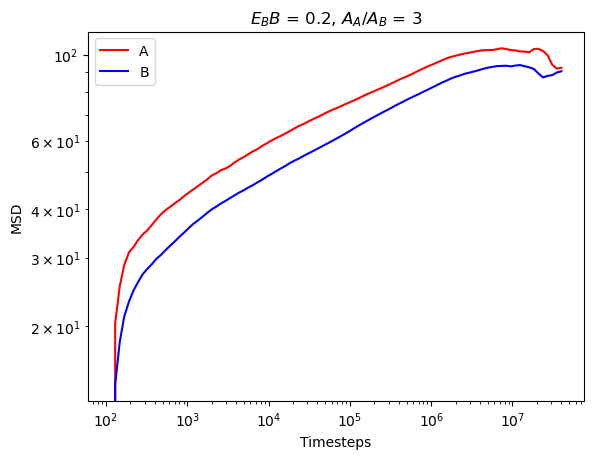

In [39]:
# generate intermediate data
# extract some conformations
i = 9
chromo = 'simple1_logclustered'
path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/artificial_chr/{chromo}/{simnames[i]}'
start_i = 0
end_i = 1109
conformations, runs = extract_conformations(path)
np.save(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/conformations/{chromo}/{simnames[i]}', conformations)

# save MSDs to file. make sure to change directory to proper chromosome!
save_MSD_time_ave(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/artificial_chr/{chromo}/{simnames[i]}/runs1_0_200copies', ids, 
                      f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/msds/{chromo}/{simnames[i]}.csv', copy_range = 5)
    
# plot MSDs
datapath = Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/msds/{chromo}')
stickiness = 0.2
act = 3
plot_msds(stickiness, act, '', simnames[9])
#plot_msd_panel(simpaths)

In [5]:
# radial distribution methods
# take 100 snapshots/conformations starting from mid-time (so 2*10^7 timesteps), each 20 copies --> 2000 conformations total
# if time-clustered, take 2200 conformations (200 chains from 11-timestep window)
'''Ongoing notes:
1. g(R) should be a function centered around 1.0 since measure is non-dimensional enrichment ratio?
'''
def radial_distribution(ids, conf_path, start=10000, end=20000):
    conf = list_URIs(conf_path)
    conformations = conf[start:end]
    num_A = len(ids[ids==1]) # for normalization later
    num_B = len(ids[ids==0])
    num_confs = 0
    rsquared_A = []
    rsquared_B = []
    N = len(ids)
    for conformation in conformations:
        pos = load_URI(conformation)["pos"]
        ncopies = pos.shape[0] // N
        for i in range(ncopies):
            posN = pos[N * i : N * (i + 1)]
            posN_A = posN[ids==1]
            posN_B = posN[ids==0]
            center_mass = np.mean(posN, axis=0)
            posN_A2 = [sum((posN_A[i] - center_mass)**2) for i in range(len(posN_A))] # using COM instead of absolute center; alternatively use globule center
            posN_B2 = [sum((posN_B[i] - center_mass)**2) for i in range(len(posN_B))]
            rsquared_A.extend(posN_A2)
            rsquared_B.extend(posN_B2)
        num_confs += ncopies
    rsquared_A = [math.sqrt(rsq) for rsq in rsquared_A] # convert to r, not r^2
    rsquared_B = [math.sqrt(rsq) for rsq in rsquared_B]
    return rsquared_A, rsquared_B
    #df2 = pd.DataFrame(rsquared)
    #df2.to_csv(Path(savepath) / f"rsquared_{simstring}.csv", index=False)
    
def plot_radial_dist(rsquared_A, rsquared_B, stickiness, act, ax=None, start=10000, end=20000, blocks=False):
    if ax is None:
        fig, ax = plt.subplots()
    num_bins = 100 # change back to 100
    binwidth = (max(rsquared_A + rsquared_B) - min(rsquared_A + rsquared_B))/num_bins
    bins = np.arange(min(rsquared_A + rsquared_B), max(rsquared_A + rsquared_B)+binwidth, binwidth)
    
    r_chain = (((num_A+num_B) * (0.5) ** 3) / 0.2) ** (1 / 3) # approximately 9
    width = 10.0
    r = r_chain + width 
    phi_A = num_A*2200/(4/3*math.pi*r**3) # where 2200 is number of conformations (200 copies * 11 snapshots)
    phi_B = num_B*2200/(4/3*math.pi*r**3)
    
    n_a, bins_a = np.histogram(rsquared_A, bins=bins)
    n_b, bins_b = np.histogram(rsquared_B, bins=bins)
    new_a = []
    new_b = []
    for j in range(len(n_a)):
        shell_volume = 4*math.pi*((bins_a[j+1] + bins_a[j])/2)**2 # take R as the middle of a bin. bins_a and bins_b should be same
        new_a.append(n_a[j]/(phi_A*shell_volume*binwidth))
        new_b.append(n_b[j]/(phi_B*shell_volume*binwidth))
        
    ax.hist(bins_a[:-1], bins=bins_a, weights=new_a, color='r', label='A', alpha=0.5)
    ax.hist(bins_b[:-1], bins=bins_b, weights=new_b, color='b', label='B', alpha=0.5)

    ax.set_xlabel('Distance from COM, R')
    ax.set_ylabel('g(R)')
    ax.legend()
    if (blocks):
        ax.set_title(f'blocks{start}-{end}')
    else:
        ax.set_title(f'$E_BB$ = {stickiness}, $A_A / A_B$ = {act}')
    
def plot_radial_panel(simpaths):
    num_rows = 5
    num_cols = 5
    fig = plt.figure(figsize=(3*num_cols, 2 + 2*num_rows))
    #extract activity / stickiness from simpath name
    BBenergy = np.array([float(simname.split('_')[1]) for simname in simpaths])
    activities = np.array([float(simname.split('act')[1]) for simname in simpaths])
    fig.suptitle('Radial distribution', fontsize=14, fontweight='bold')
    gs = GridSpec(nrows=num_rows, ncols=num_cols, width_ratios=[100]*num_cols)
    for i in range(len(simpaths)):
        x = i // num_cols
        y = i % num_cols
        ax = fig.add_subplot(gs[x, y])
        conf_path = f"/home/gridsan/lchan/git-remotes/polychrom_analysis/artificial_chr/{chromo}/{simpaths[i]}/runs20000_2000_20copies"
        rsq_A, rsq_B = radial_distribution(ids, conf_path)
        plot_radial_dist(rsq_A, rsq_B, BBenergy[i], activities[i], ax=ax)

        if np.all(activities == activities[0]):
            ax.set_title(r'$E_{BB}=$' + f'${BBenergy[i]}kT$', fontsize=12)
        elif np.all(BBenergy == BBenergy[0]):
            ax.set_title(f'$A_A/A_B={activities[i]}$', fontsize=12)
        else:
            ax.set_title(r'$E_{BB}=$' + f'${BBenergy[i]}kT$' + f' $A_A/A_B={activities[i]}$', fontsize=12)
            
    fig.tight_layout()
    plt.show()

def plot_radial_dynamics_panel(simpaths, blocks=False, index=0):
    num_rows = 10
    num_cols = 10
    fig = plt.figure(figsize=(3*num_cols, 2 + 2*num_rows))
    #extract activity / stickiness from simpath name
    BBenergy = np.array([float(simname.split('_')[1]) for simname in simpaths])
    activities = np.array([float(simname.split('act')[1]) for simname in simpaths])
    fig.suptitle('Radial distribution dynamics', fontsize=14, fontweight='bold')
    gs = GridSpec(nrows=num_rows, ncols=num_cols, width_ratios=[100]*num_cols)
    start_i_list = list(range(0, 1090, 11))
    end_i_list = list(range(10, 1100, 11))
    for i in range(len(start_i_list)):
        x = i // num_cols
        y = i % num_cols
        ax = fig.add_subplot(gs[x, y])
        conf_path = f"/home/gridsan/lchan/git-remotes/polychrom_analysis/artificial_chr/{chromo}/{simpaths[index]}/runs1_0_200copies" # change the run/copy number if not doing time-clustered
        if (blocks):
            start = start_i_list[i]
            end = end_i_list[i]
            rsq_A, rsq_B = radial_distribution(ids, conf_path, start=start, end=end)
            plot_radial_dist(rsq_A, rsq_B, BBenergy[0], activities[0], ax=ax, start=start, end=end, blocks=True)
                                                 
        else:
            rsq_A, rsq_B = radial_distribution(ids, conf_path)
            plot_radial_dist(rsq_A, rsq_B, BBenergy[i], activities[i], ax=ax)

            if np.all(activities == activities[0]):
                ax.set_title(r'$E_{BB}=$' + f'${BBenergy[i]}kT$', fontsize=12)
            elif np.all(BBenergy == BBenergy[0]):
                ax.set_title(f'$A_A/A_B={activities[i]}$', fontsize=12)
            else:
                ax.set_title(r'$E_{BB}=$' + f'${BBenergy[i]}kT$' + f' $A_A/A_B={activities[i]}$', fontsize=12)
            
    fig.tight_layout()
    plt.savefig(f'data/figures/{chromo}/{simpaths[index]}_radial_dynamics.png')
    plt.show()
    
def radial_polarization(ids, conf_path, start=10000, end=20000, single_chain = False):
    conf = list_URIs(conf_path)
    conformations = conf[start:end]
    num_A = len(ids[ids==1]) # for normalization later
    num_B = len(ids[ids==0])
    N = len(ids)
    polarization_dists = []
    for conformation in conformations:
        pos = load_URI(conformation)["pos"]
        ncopies = pos.shape[0] // N
        if single_chain:
            ncopies = 1
        for i in range(ncopies):
            posN = pos[N * i : N * (i + 1)]
            posN_A = posN[ids==1]
            posN_B = posN[ids==0]
            center_mass_A = np.mean(posN_A, axis=0)
            center_mass_B = np.mean(posN_B, axis=0)
            polarization_dist = 0
            for j in range(3):
                polarization_dist += (center_mass_A[j] - center_mass_B[j])**2
            polarization_dist = math.sqrt(polarization_dist) # take absolute value, r = sqrt(x^2 + y^2 + z^2)
            polarization_dists.append(polarization_dist)
    mean_polarization_dist = np.mean(polarization_dist)
    return mean_polarization_dist

def plot_radial_polarization(conf_path, ax = None, single_chain = False):
    conf = list_URIs(conf_path)
    
    # for each start end corresponding to a conformation of 11 timepoints
    start_i_list = list(range(0, 1090, 11))
    end_i_list = list(range(10, 1100, 11))
    polarization_dists = [] # across all blocks
    for i in range(len(start_i_list)):
        start = start_i_list[i]
        end = end_i_list[i]
        mean_polarization_dist = radial_polarization(ids, conf_path, start, end, single_chain = single_chain) # corresponding to 1 timeshot
        polarization_dists.append(mean_polarization_dist)
        
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_xlabel('Timesteps')
    ax.set_ylabel('Distance between A and B COM')
    timepoints = np.rint(np.logspace(np.log10(100), np.log10(10000*4000), 100))
    ax.plot(timepoints, polarization_dists)
    ax.set_xscale('log')
    ax.legend()
    ax.set_ylim(bottom = 0, top = 10)
    #ax.set_title(f'$E_BB$ = {stickiness}, $A_A / A_B$ = {act}')
    

In [51]:
# plot radial polarization dynamics
num_A = 651
num_B = 650
#plot_radial_dynamics_panel([simnames[0]], blocks=True, index=0)

conf_path = f"/home/gridsan/lchan/git-remotes/polychrom_analysis/artificial_chr/{chromo}/{simnames[9]}/runs1_0_200copies"
plot_radial_polarization(conf_path, single_chain = True)

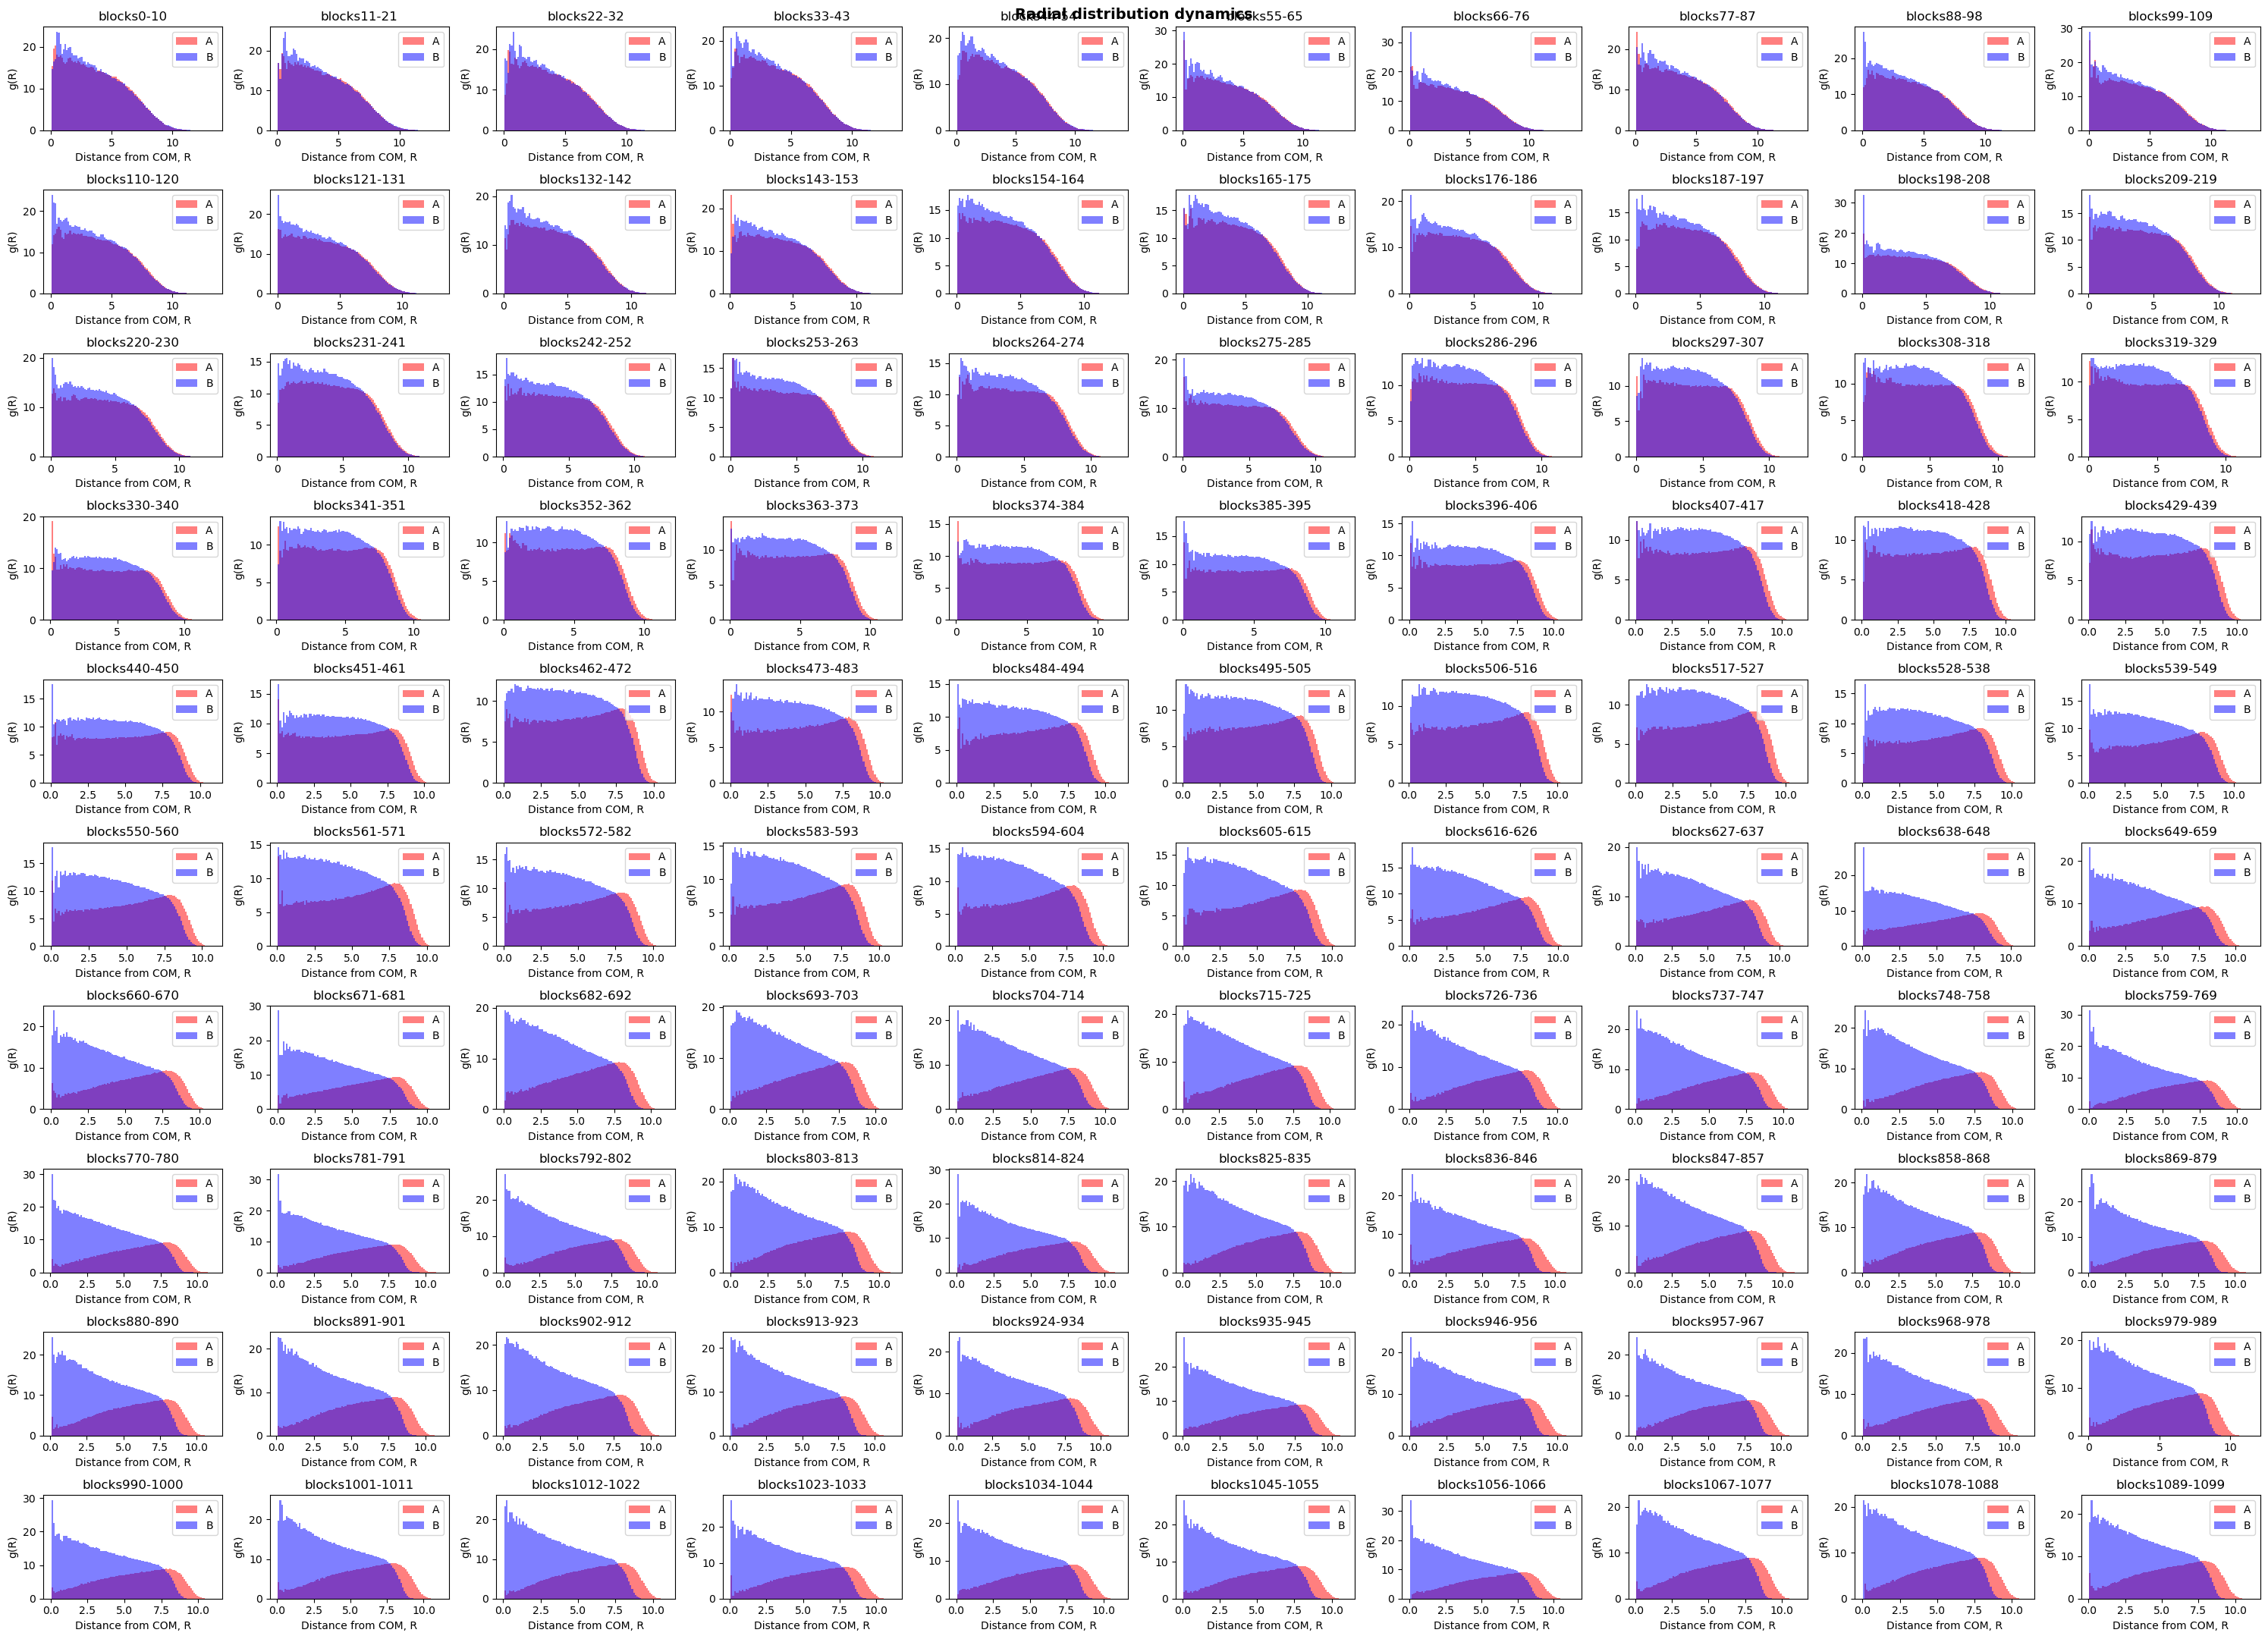

In [53]:
# plot radial distribution dynamics
num_A = 651
num_B = 650
plot_radial_dynamics_panel([simnames[9]], blocks=True, index=9)

In [6]:
# contact map / compscore methods
# Plot example contact maps for fixed activity, varying sticky interactions
# overwrite method for parameter defaults
def extract_cs(path, every_other=1): # starts and ends are fake here. modify in real code
    """Extract independent snapshots from a single simulation.

    Parameters
    ----------
    path : str
        path to simulation directory
    start : int
        block number to start extracting files from
    every_other : int
        skip this number of blocks in between snapshots (should be large enough
        so that snapshots are decorrelated)
    end : int
        last block to include in trajectory.
    """
    try:
        confs = list_URIs(path)
        if end:
            uris = confs[start:end:every_other]
        else:
            uris = confs[start::every_other]
    except:
        raise Exception("Exception! Something went wrong")
        uris = []
    return uris
def extract_conformations_cs(basepath, ncores=24, chain=True, **kwargs):
    """Extract conformations from multiple simulation replicates to be included in
    ensemble-averaged observables.

    Parameters
    ----------
    basepath : str or Path
        parent directory where each subdirectory is a simulation replicate for one set of parameters
    ncores : int
        number of cores available for parallelization
    chain : bool
        whether to aggregate conformations from multiple simulations into one list.
        Defaults to True.

    Returns
    -------
    conformations : list
        If chain is True, list of hdf5 filenames containing polymer conformations.
        If chain is False, list of lists, where each sublist is from a separate simulation run.
    """
    basepath = Path(basepath)
    rundirs = [f for f in basepath.iterdir() if f.is_dir()]
    runs = len(rundirs)
    extract_func = partial(extract_cs, **kwargs)
    with mp.Pool(ncores) as p:
        confs = p.map(extract_func, rundirs)
    if chain:
        conformations = list(itertools.chain.from_iterable(confs))
        #print(f"Number of simulations in directory: {runs}")
        #print(f"Number of conformations extracted: {len(conformations)}")
        return conformations, runs
    else:
        return confs, runs
def plot_contact_maps(simpaths, datapath=Path('/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps'), index=0):
    print(simpaths)
    num_rows = 10
    num_cols = 10
    fig = plt.figure(figsize=(3*num_cols, 2 + 2*num_rows))
    #extract activity / stickiness from simpath name -- depends on your naming convention!
    BBenergy = np.array([float(simname.split('_')[1]) for simname in simpaths])
    activities = np.array([float(simname.split('_')[2][3:]) for simname in simpaths])
    print(BBenergy)
    print(activities)
    
    #fix activity ratio and plot contact maps for varying E0
    if np.all(activities == activities[0]):
        fig.suptitle(f'Ensemble averaged contact maps for $A_A/A_B={activities[0]}$', 
                     fontsize=14, fontweight='bold')
        
    #fix E0 and plot contact maps for varying activity ratio
    elif np.all(BBenergy == BBenergy[0]):
        fig.suptitle(f'Ensemble averaged contact maps for $E_0={BBenergy[0]}$', 
                     fontsize=14, fontweight='bold')
        
    #fix comp score but vary E0 and activity ratio simultaneously
    else:
        fig.suptitle("Contact maps for models", fontsize=14, fontweight='bold')
        
    gs = GridSpec(nrows=num_rows, ncols=num_cols, 
                  width_ratios=[100]*num_cols)
    
    for i in range(len(blocks)): # change if plotting dynamics across a single parameter pair, change to simpaths
        x = i // num_cols
        y = i % num_cols
        ax = fig.add_subplot(gs[x, y])
        #divide axis for colorbars
        divider = make_axes_locatable(ax)
        ax_top = divider.append_axes("top", size=f"5%", pad=0.0)
        ax_left = divider.append_axes("left", size=f"5%", pad=0.0)
        cax = divider.append_axes("right", size=f"5%", pad=0.1)
        #purposely not plotting tick labels here -- would just be monomer id
        ax_top.set_xticks([])
        ax_top.set_yticks([])
        ax_left.set_xticks([])
        ax_left.set_yticks([])
        ax.set_xticks([])
        ax.set_yticks([])
        #make a colorbar where red is A and blue is B
        N = len(ids)
        act_values = np.ones(N)
        act_values[ids==0] = 0.1
        act_values[ids==1] = 0.9
        ABplot = np.ones((int(5*0.01*N), N))
        for j in range(int(5*0.01* N)):
            ABplot[j, :] = act_values
        
        mat = np.load(datapath/f'contact_map_{simpaths[index]}_cutoff2.0_blocks{blocks[i]}.npy') # modify this for alternate naming scheme, change 0 to i
        mat /= mat.max()
        mat[mat == 0] = mat[mat > 0].min() / 2
        lognorm = LogNorm(vmin=mat.min(), vmax=mat.max())
        im = ax.imshow(mat, norm=lognorm, cmap='YlOrRd')
        #plot colorbars showing A/B identities (red is A, blue is B)
        ax_top.imshow(ABplot, cmap="coolwarm", vmin=0, vmax=1)
        ax_left.imshow(ABplot[:, ::-1].T, cmap="coolwarm", origin="lower", vmin=0, vmax=1)
        if np.all(activities == activities[0]):
            ax.set_title(r'$E_{BB}=$' + f'${BBenergy[0]}kT$', pad=15, fontsize=12) #change 0 to i
        elif np.all(BBenergy == BBenergy[0]):
            ax.set_title(f'$A_A/A_B={activities[0]}$', pad=15, fontsize=12) #change 0 to i
        else:
            ax.set_title(r'$E_{BB}=$' + f'${BBenergy[0]}kT$' + f' $A_A/A_B={activities[0]}$',  #change 0 to i
                         pad=15, fontsize=12)
        plt.colorbar(im, cax=cax)
    plt.savefig(f'data/figures/{chromo}/{simpaths[index]}_contact_map_dynamics.png')
    fig.tight_layout()

# overwrite compscore method for naming conventions
def plot_comp_score_1(acts, E0s):
    """ Compute and plot comp score as a function of distance from diagonal."""
    datapath = Path('/home/gridsan/lchan/git-remotes/polychrom_analysis/data/')
    fig, ax = plt.subplots()
    sdistances = np.arange(1, 1302)
    for act, E0 in zip(acts, E0s):
        filename = datapath/f'contact_maps/{chromo}/contact_map_stickyBB_{E0}_act{act}_cutoff2.0.npy' # change as needed
        cs, csA, csB = comp_score_1(str(filename), ids)
        ax.plot(sdistances, cs, label=f'$E_BB=${E0}, $A_A / A_B$={act}')
    if np.all(acts == acts[0]):
        ax.set_title(f"Comp score 1 for $A_A/A_B$={acts[0]}")
    elif np.all(E0s == E0s[0]):
        ax.set_title(f"Comp score 1 for $E_BB$={E0s[0]}")
    ax.set_xlabel("s")
    ax.set_ylabel("COMP score")
    plt.legend()
    fig.tight_layout()
    plt.show()

def create_starting_df(df_pathname):
    df = pd.DataFrame(columns=['act_ratio', 'E0', 'cs1', 'cs1_A', 'cs1_B'])
    df.to_csv(df_pathname)

#compute comp score on all simulation data that exists so far
def compute_comp_score_all_data(datapath=Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), cs_start=200, cs_end=1000):
    df_path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/comp_scores/cs1_{chromo}.csv'
    if (Path.exists(Path(df_path))):
        df = pd.read_csv(df_path)
    else:
        create_starting_df(df_path)
        df = pd.read_csv(df_path)
    df_a = df.set_index(['E0', 'act_ratio'])
    dict_list = []
    i = 0
    for filename in datapath.glob("*cutoff2.0*"):
        name_words = str(filename.name).split('_')
        E0 = float(name_words[3])
        act = float(name_words[4][3:])
        if df_a.index.isin([(E0, act)]).any():
            continue
        i += 1
        cs, csA, csB = comp_score_1(str(filename), ids)
        dict_list.append({"act_ratio" : act, "E0" : E0, "cs1" : np.nanmean(cs[cs_start: cs_end]),
                   "cs1_A" : np.nanmean(csA[cs_start:cs_end]), "cs1_B" : np.nanmean(csB[cs_start:cs_end])})
    print(f"Computed comp scores from {i} new simulations")
    df_b = pd.DataFrame.from_dict(dict_list)
    newdf = pd.concat([df, df_b], axis=0)
    newdf.to_csv(df_path)
    return newdf

# plot contour map
def plot_contour_map(df, blocks=None):
    if (blocks):
        df = df[df['blocks'] == blocks]
    acts = np.unique(df['act_ratio'])
    acts = acts[acts%1==0] # subset if necessary
    E0s = np.unique(df['E0'])
    E0s = E0s[E0s%0.075==0] # subset if necessary
    print(acts, E0s)
    act_grid, E0_grid = np.meshgrid(acts, E0s, indexing='xy')
    cs_Ascores = np.zeros((len(E0s), len(acts)))
    cs_Bscores = np.zeros((len(E0s), len(acts)))
    for i in range(len(acts)):
        for j in range(len(E0s)): 
            row = df.loc[(df["act_ratio"] == act_grid[j, i]) & (df["E0"] == E0_grid[j, i])]
            cs_Ascores[j, i] = float(row['cs1_A'].values[0])
            cs_Bscores[j, i] = float(row['cs1_B'].values[0])
    slide_width = 11.5
    fig, (axA, axB) = plt.subplots(1, 2, figsize=(slide_width, 0.5*slide_width))
    levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0] # gradient colorbar
    imA = axA.contourf(act_grid, E0_grid, cs_Ascores, cmap='plasma', levels=levels, vmax=1.0)
    imB = axB.contourf(act_grid, E0_grid, cs_Bscores, cmap='plasma', levels=levels, vmax=1.0)
    axA.set_title('A compartment score')
    axB.set_title('B compartment score')
    axA.set_xlabel(r'$A_A/ A_B$')
    axB.set_xlabel(r'$A_A/ A_B$')
    axA.set_ylabel(r'$E_{BB}$')
    fig.colorbar(imA, ax=axA)
    fig.colorbar(imB, ax=axB)

def select_contour_param(df, select_act, select_e0, blocks=None):
    if (blocks):
        df = df[df['blocks'] == blocks]
    acts = np.unique(df['act_ratio'])
    acts = acts[acts%1==0] # subset if necessary
    E0s = np.unique(df['E0'])
    E0s = E0s[E0s%0.075==0] # subset if necessary
    print(acts, E0s)
    act_grid, E0_grid = np.meshgrid(acts, E0s, indexing='xy')
    cs_Ascores = np.zeros((len(E0s), len(acts)))
    cs_Bscores = np.zeros((len(E0s), len(acts)))
    for i in range(len(acts)):
        for j in range(len(E0s)): 
            row = df.loc[(df["act_ratio"] == act_grid[j, i]) & (df["E0"] == E0_grid[j, i])]
            cs_Ascores[j, i] = float(row['cs1_A'].values[0])
            cs_Bscores[j, i] = float(row['cs1_B'].values[0])
            
    slide_width = 11.5
    plot_points = True
    fig, (axA) = plt.subplots(1, 1, figsize=(0.8 * slide_width, 0.5 * slide_width))
    levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    imA = axA.contourf(act_grid[0:11, 0:11], E0_grid[0:11, 0:11],
                       cs_Bscores[0:11, 0:11], cmap='plasma',
                       levels=levels,
                       vmax=1.0)
    
    #mark models that all have a comp score of ~ 0.3
    if plot_points:
        axA.plot(select_act, select_e0, '*', markeredgecolor='black',
                 markerfacecolor='white', markersize=12)
    fig.colorbar(imA, ax=axA)
    axA.set_title('B compartment score')
    axA.set_xlabel(r'$A_A / A_B$')
    axA.set_ylabel(r'$E_{BB}$')
    fig.tight_layout()

# create new df if new simulation path
def create_starting_dynamic_df(df_pathname):
    df = pd.DataFrame(columns=['act_ratio', 'E0', 'blocks', 'cs1', 'cs1_A', 'cs1_B']) # added blocks
    df.to_csv(df_pathname)

# design new method to plot compscores over time (i.e. over blocks)
# store in a table with columns of act_ratio, e0, blockset
def plot_dynamic_comp_score_1(acts, E0s, chromo, compartment=None, normalize=False, cs_start=200, cs_end=1000):
    """ Compute and plot comp score as a function of time (blocks).
        (string) compartment: defaults to None. select 'a' or 'b' or 'ab' to choose compartments' score.
        (boolean) normalize: defaults to False. normalizes to end-state value for dynamics. 
        (int) cs_start, cs_end: what portions of polymer/contact map to calculate the comp score from.
        """
    fig, ax = plt.subplots()
    timepoints = np.rint(np.logspace(np.log10(100), np.log10(10000*4000), 100))
    timepoints = list(timepoints.astype(int))
    df_path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/comp_scores/cs1_{chromo}_{cs_start}-{cs_end}.csv'
    if (Path.exists(Path(df_path))):
        df = pd.read_csv(df_path)
    else:
        df_path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/comp_scores/cs1_{chromo}.csv'
        df = pd.read_csv(df_path)
    for act, E0 in zip(acts, E0s):
        param_pair = df[df['act_ratio']==act][df['E0']==E0]
        param_pair = param_pair.sort_values('blocks')
        cs = list(param_pair['cs1'])
        csA = list(param_pair['cs1_A'])
        csB = list(param_pair['cs1_B'])
        if (normalize): # normalize the compscores to the steady-state or end value
            cs_end = cs[-1]
            csA_end = csA[-1]
            csB_end = csB[-1]
            cs = [item/cs_end for item in cs]
            csA = [item/csA_end for item in csA]
            csB = [item/csB_end for item in csB]
        if compartment == 'a':
            ax.plot(timepoints, csA, label=f'$E_BB=${E0}, $A_A / A_B$={act}')
        elif compartment == 'b':
            ax.plot(timepoints, csB, label=f'$E_BB=${E0}, $A_A / A_B$={act}')
        elif compartment == 'ab':
            ax.plot(timepoints, csA, label=f'$E_BB=${E0}, $A_A / A_B$={act}, A')
            ax.plot(timepoints, csB, label=f'$E_BB=${E0}, $A_A / A_B$={act}, B')
        else:    
            ax.plot(timepoints, cs, label=f'$E_BB=${E0}, $A_A / A_B$={act}')
    if np.all(acts == acts[0]):
        ax.set_title(f"Comp score 1 for $A_A/A_B$={acts[0]}")
    elif np.all(E0s == E0s[0]):
        ax.set_title(f"Comp score 1 for $E_BB$={E0s[0]}")
    ax.set_xlabel("Timesteps")
    ax.set_ylabel("COMP score")
    if (normalize):
        ax.set_ylabel("Normalized COMP score")
        ax.set_ylim(0.0, 1.3)
    ax.set_xscale('log')
    plt.legend()
    fig.tight_layout()
    plt.show()

#compute comp score on all simulation data that exists so far
def compute_dynamic_comp_score_all_data(chromo, datapath=Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids=None, cs_start=200, cs_end=1000):
    print(datapath)
    df_path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/comp_scores/cs1_{chromo}_{cs_start}-{cs_end}.csv'
    if (Path.exists(Path(df_path))):
        df = pd.read_csv(df_path)
    else:
        create_starting_dynamic_df(df_path)
        df = pd.read_csv(df_path)
    df_a = df.set_index(['E0', 'act_ratio', 'blocks'])
    dict_list = []
    i = 0
    for filename in datapath.glob("*cutoff2.0*"):
        name_words = str(filename.name).split('_')
        E0 = float(name_words[3])
        act = float(name_words[4][3:])
        blocks = int(name_words[6].split('.npy')[0].split('-')[0][6:])
        if df_a.index.isin([(E0, act, blocks)]).any():
            continue
        i += 1
        cs, csA, csB = comp_score_1(str(filename), ids)
        dict_list.append({"act_ratio" : act, "E0" : E0, "blocks" : blocks, "cs1" : np.nanmean(cs[cs_start:cs_end]),
                   "cs1_A" : np.nanmean(csA[cs_start:cs_end]), "cs1_B" : np.nanmean(csB[cs_start:cs_end])})
    print(f"Computed comp scores from {i} new simulations")
    df_b = pd.DataFrame.from_dict(dict_list)
    newdf = pd.concat([df, df_b], axis=0)
    newdf.to_csv(df_path)
    return newdf

import seaborn as sns
from matplotlib.colors import ListedColormap
def plot_diagonal_diffs(act, E0, chromo, compartment=None, normalize=False):
    """ Compute and plot comp score as a function of time (blocks).
        (float) act, E0: a pair of values. only visualizes one pair at a time.
        (string) compartment: defaults to None. select 'a' or 'b' or 'ab' to choose compartments' score.
        (boolean) normalize: defaults to False. normalizes to end-state value for dynamics. 
        """
    fig, ax = plt.subplots()
    timepoints = np.rint(np.logspace(np.log10(100), np.log10(10000*4000), 100))
    timepoints = list(timepoints.astype(int))
    cs_intervals = [(200, 1000), (0, 250), (250, 500), (500, 750), (750, 1000)]
    
    colors = sns.color_palette("viridis")
    i = 0 # for coloring purposes
    for (cs_int_start, cs_int_end) in cs_intervals:
        df_path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/comp_scores/cs1_{chromo}_{cs_int_start}-{cs_int_end}.csv'
        if (Path.exists(Path(df_path))):
            df = pd.read_csv(df_path)
        else:
            df_path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/comp_scores/cs1_{chromo}.csv'
            df = pd.read_csv(df_path)
        param_pair = df[df['act_ratio']==act][df['E0']==E0]
        param_pair = param_pair.sort_values('blocks')
        cs = list(param_pair['cs1'])
        csA = list(param_pair['cs1_A'])
        csB = list(param_pair['cs1_B'])
        if (normalize): # normalize the compscores to the steady-state or end value
            cs_end = cs[-1]
            csA_end = csA[-1]
            csB_end = csB[-1]
            cs = [item/cs_end for item in cs]
            csA = [item/csA_end for item in csA]
            csB = [item/csB_end for item in csB]
        if compartment == 'a':
            ax.plot(timepoints, csA, label=f'$E_BB=${E0}, $A_A / A_B$={act}, {cs_int_start}-{cs_int_end}', color = colors[i])
        elif compartment == 'b':
            ax.plot(timepoints, csB, label=f'$E_BB=${E0}, $A_A / A_B$={act}, {cs_int_start}-{cs_int_end}', color = colors[i])
        elif compartment == 'ab':
            ax.plot(timepoints, csA, label=f'$E_BB=${E0}, $A_A / A_B$={act}, A, {cs_int_start}-{cs_int_end}')
            ax.plot(timepoints, csB, label=f'$E_BB=${E0}, $A_A / A_B$={act}, B, {cs_int_start}-{cs_int_end}')
        else:    
            ax.plot(timepoints, cs, label=f'$E_BB=${E0}, $A_A / A_B$={act}, {cs_int_start}-{cs_int_end}', color = colors[i])
        
        i+=1 # for coloring purposes
    ax.set_xlabel("Timesteps")
    ax.set_ylabel("COMP score")
    if (normalize):
        ax.set_ylabel("Normalized COMP score")
        ax.set_ylim(0.0, 1.3)
    ax.set_xscale('log')
    plt.legend()
    fig.tight_layout()
    plt.show()

In [20]:
# generate and save data for contact maps
simpath = [simnames[9]]
for simname in simpath:
    path = f'/home/gridsan/lchan/git-remotes/polychrom_analysis/artificial_chr/{chromo}/{simname}'
    # for all pairs of start_i and end_i (0, 10), (11, 21), (22, 32)...(1089, 1099)
    start_i_list = list(range(0, 1090, 11))
    end_i_list = list(range(10, 1100, 11))
    print(simname)
    for j in range(len(start_i_list)): # same as start_j length
        start = start_i_list[j]
        end = end_i_list[j]
        blocks = f'{start}-{end}'
        set_cutoff = 2.0
        if (Path(path).is_dir() and not Path(f"data/contact_maps/{chromo}/contact_map_{simname}_cutoff{set_cutoff}_blocks{blocks}.npy").is_file()):
            conformations, runs = extract_conformations_cs(path) # could save conformations if large
            mat = contactmaps.monomerResolutionContactMapSubchains(
                filenames=conformations,
                mapStarts=list(range(0, 260300, 1302)),
                mapN=1302,
                cutoff=set_cutoff
            )
            mat[mat==0] = mat[mat > 0].min() / 2
            mat2 = mat / len(conformations) / 200 # divide by 200 again for subchains
                        # save cutoff radius = 2.0 contact map
            np.save(f"data/contact_maps/{chromo}/contact_map_{simname}_cutoff{set_cutoff}_blocks{blocks}.npy", mat2)

stickyBB_0.3_act2


['stickyBB_0.3_act2']
[0.3]
[2.]


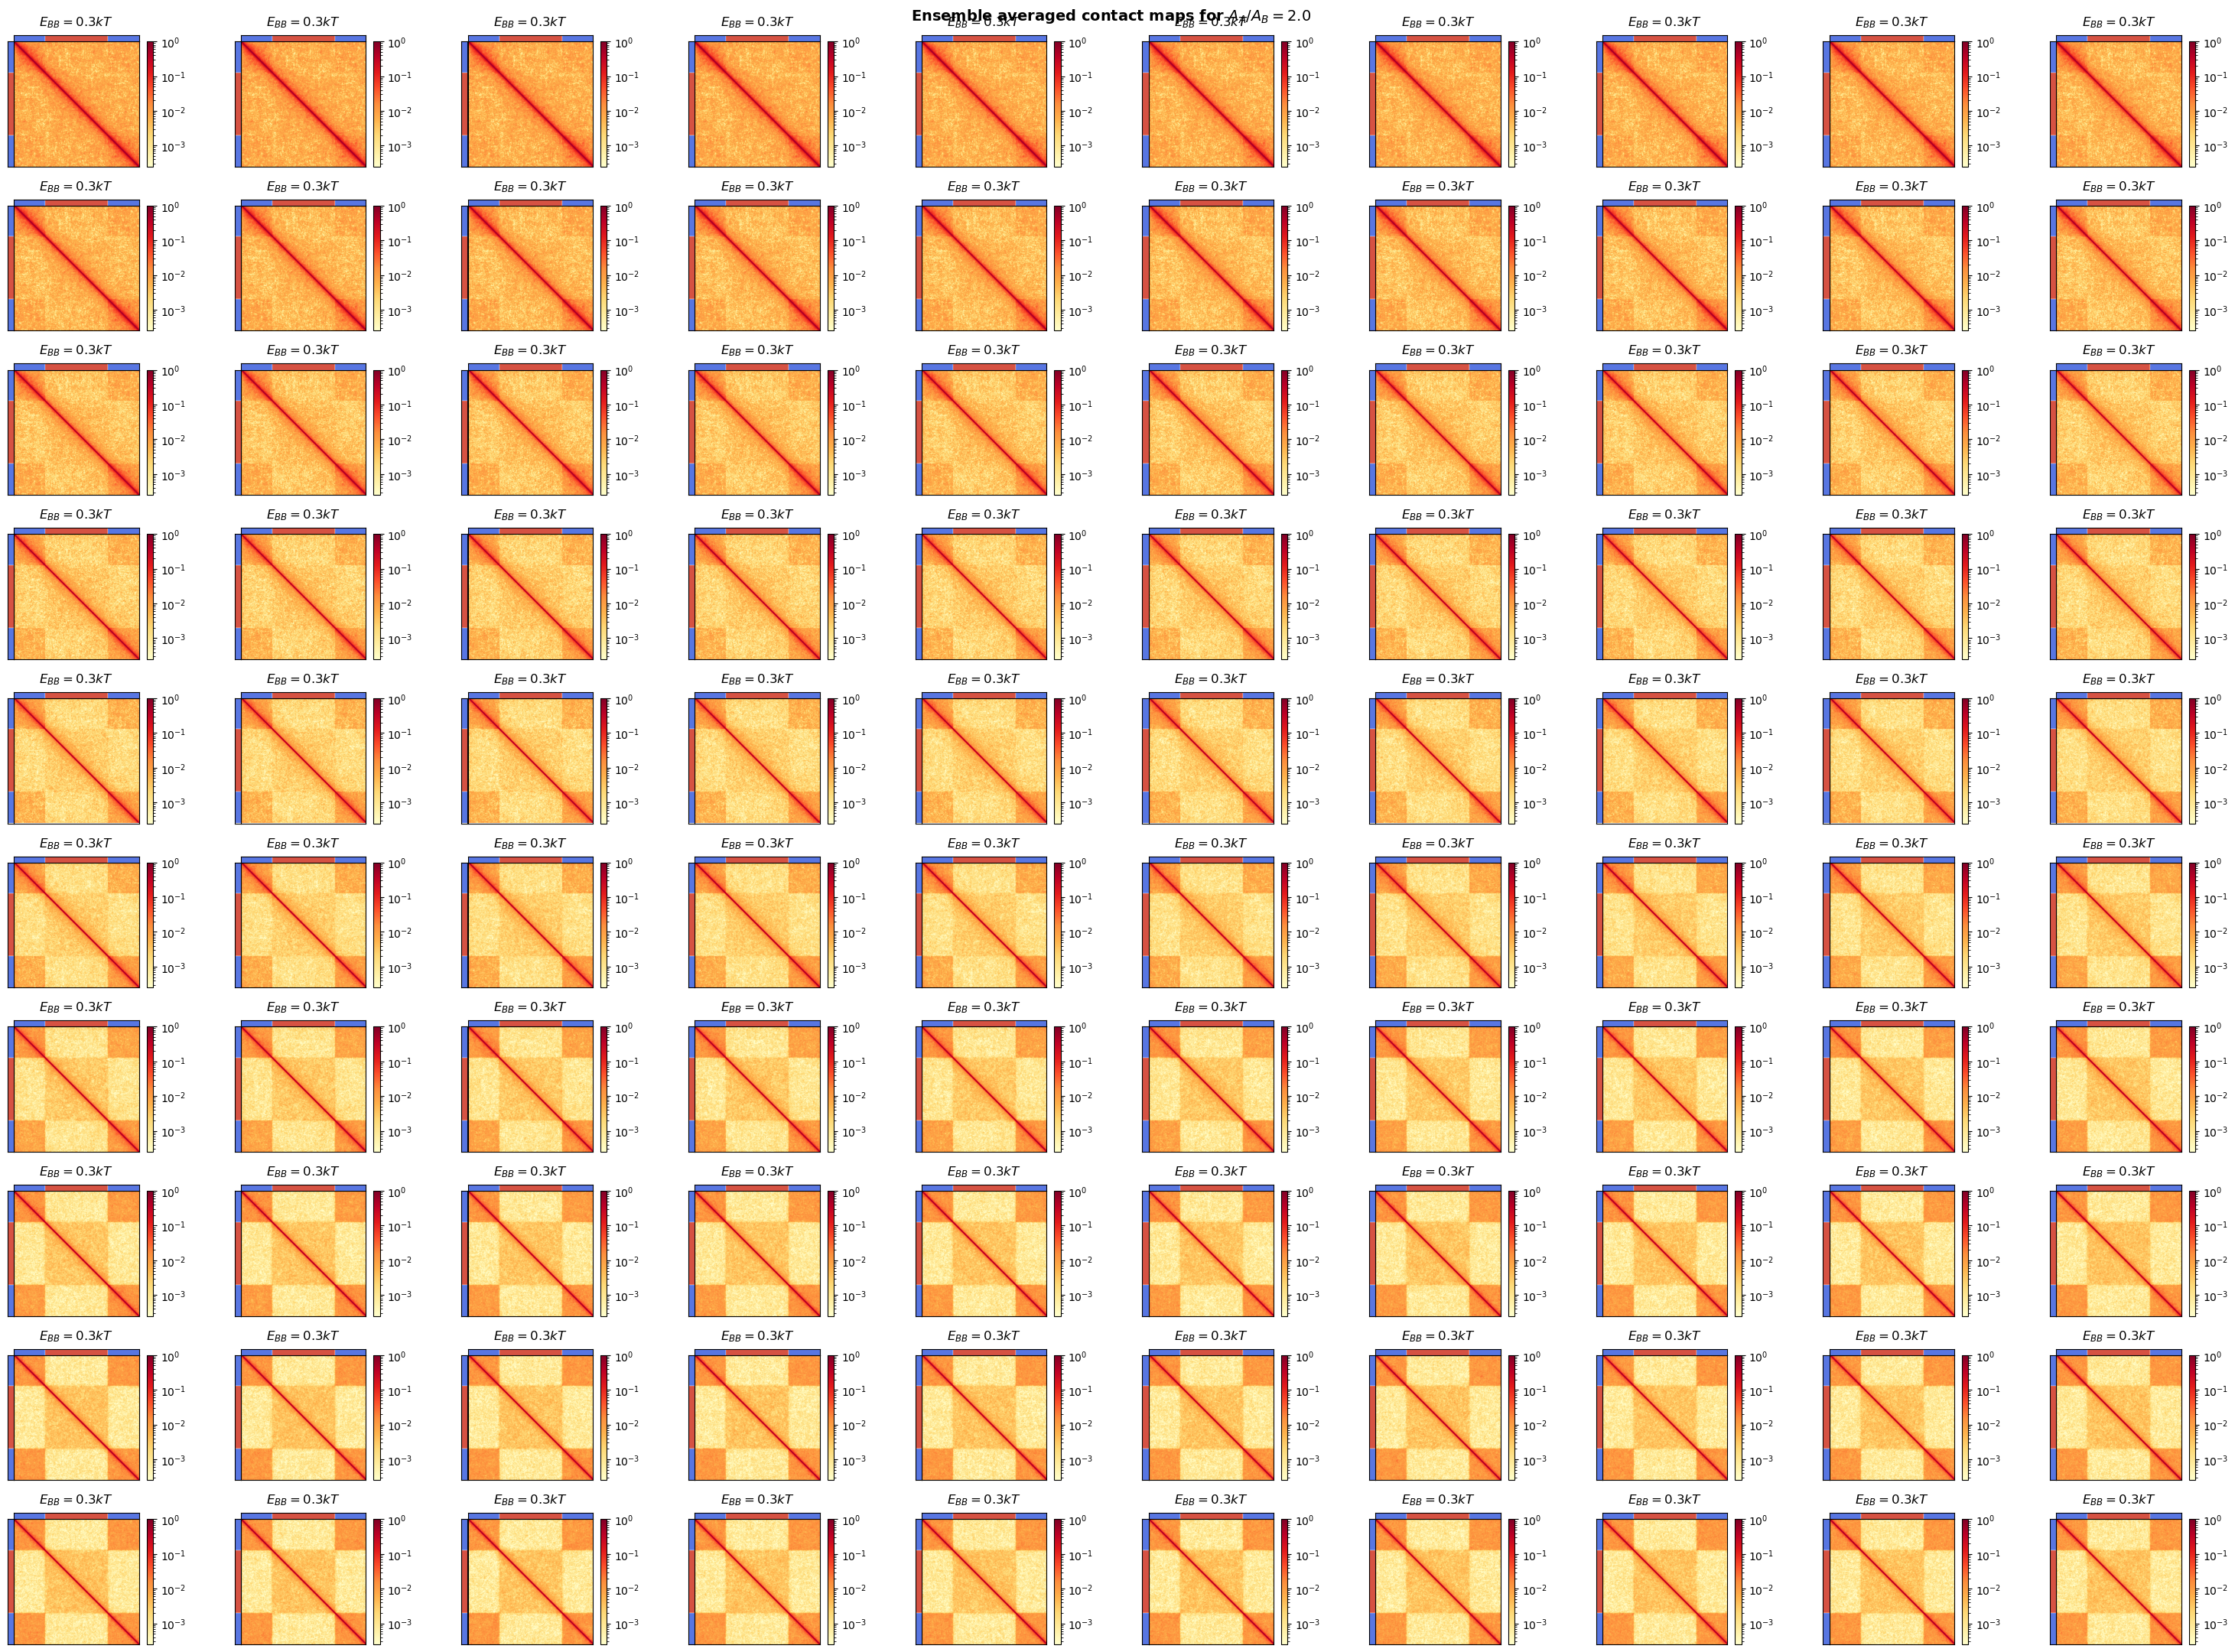

In [21]:
# plot contact maps
start_i_list = list(range(0, 1090, 11))
end_i_list = list(range(10, 1100, 11))
blocks = [f"{start_i_list[i]}-{end_i_list[i]}" for i in range(len(start_i_list))]
simpath = [simnames[9]]

plot_contact_maps(simpath, datapath=Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), index=0)

In [8]:
# create df for separated tracks
compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=200, cs_end=1000)
#compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=0, cs_end=325)
#compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=325, cs_end=651)
#compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=651, cs_end=976)
#compute_dynamic_comp_score_all_data(chromo, Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'), ids, cs_start=976, cs_end=1302)

/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/normal_logclustered
Computed comp scores from 2500 new simulations


Unnamed: 0  act_ratio     E0 blocks       cs1     cs1_A     cs1_B
0           NaN        1.0  0.000    946 -0.007977  0.005999 -0.008910
1           NaN        1.0  0.150    682  0.308748  0.234005  0.328314
2           NaN        2.0  0.000    429  0.045442 -0.034875  0.063273
3           NaN        3.0  0.225    319  0.334865  0.089288  0.374084
4           NaN        5.0  0.000    825  0.268356  0.226655  0.278505
...         ...        ...    ...    ...       ...       ...       ...
2495        NaN        3.0  0.150    374  0.230478  0.045470  0.263019
2496        NaN        2.0  0.300     22  0.108672 -0.055827  0.140064
2497        NaN        2.0  0.300    396  0.426120  0.138980  0.469196
2498        NaN        5.0  0.225    704  0.812248  0.563607  0.835494
2499        NaN        5.0  0.000    814  0.264670  0.220790  0.275884

[2500 rows x 7 columns]

/tmp/ipykernel_520595/1935943484.py:274: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  param_pair = df[df['act_ratio']==act][df['E0']==E0]


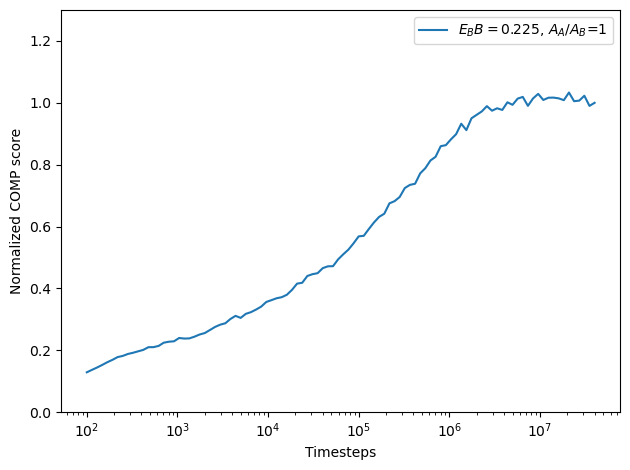

/tmp/ipykernel_520595/1935943484.py:274: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  param_pair = df[df['act_ratio']==act][df['E0']==E0]


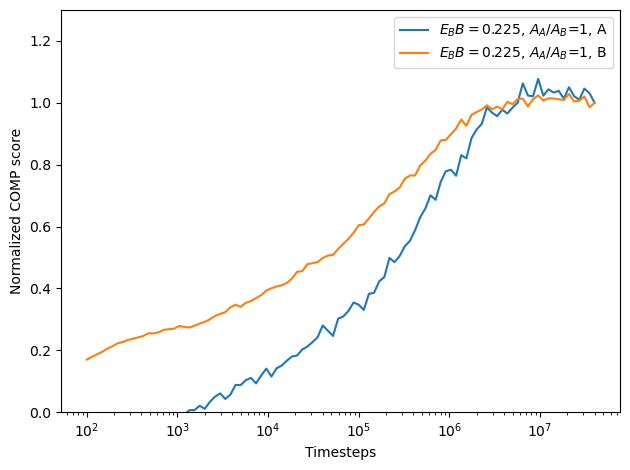

In [64]:
# plot compscore as a function of distance from diagonal
chromo = 'normal_logclustered'
acts = [1]
E0s = [0.225]
#plot_comp_score_1(acts, E0s)

#plot_dynamic_comp_score_1(acts, E0s, chromo, normalize=False) # note that acts and E0s are mapped one to one, i.e. must be same length
plot_dynamic_comp_score_1(acts, E0s, chromo, normalize=True)
plot_dynamic_comp_score_1(acts, E0s, chromo, 'ab', normalize=True)
#plot_dynamic_comp_score_1(acts2, E0s2, chromo, 'a', normalize=True)
#plot_dynamic_comp_score_1(acts2, E0s2, chromo, 'b', normalize=True)

[1. 2. 3. 4. 5.] [0.    0.075 0.15  0.3  ]
[1. 2. 3. 4. 5.] [0.    0.075 0.15  0.3  ]


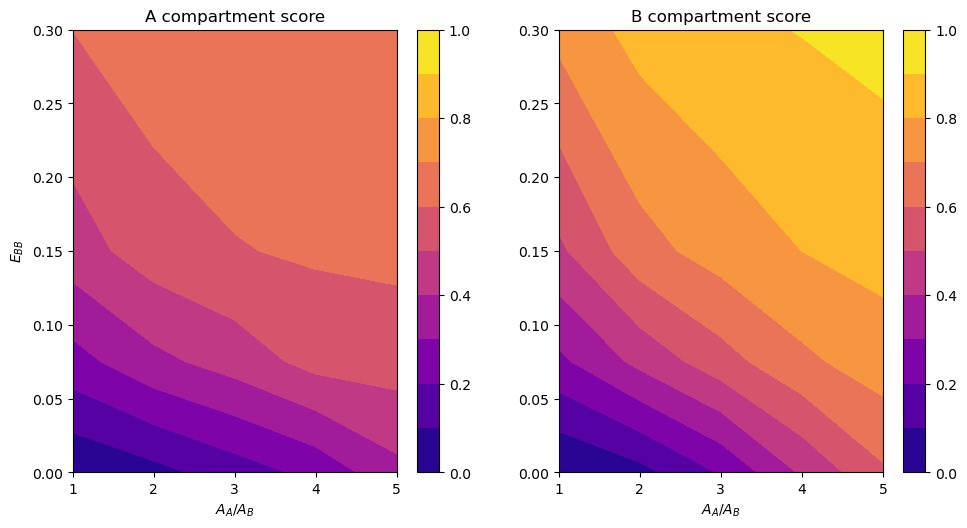

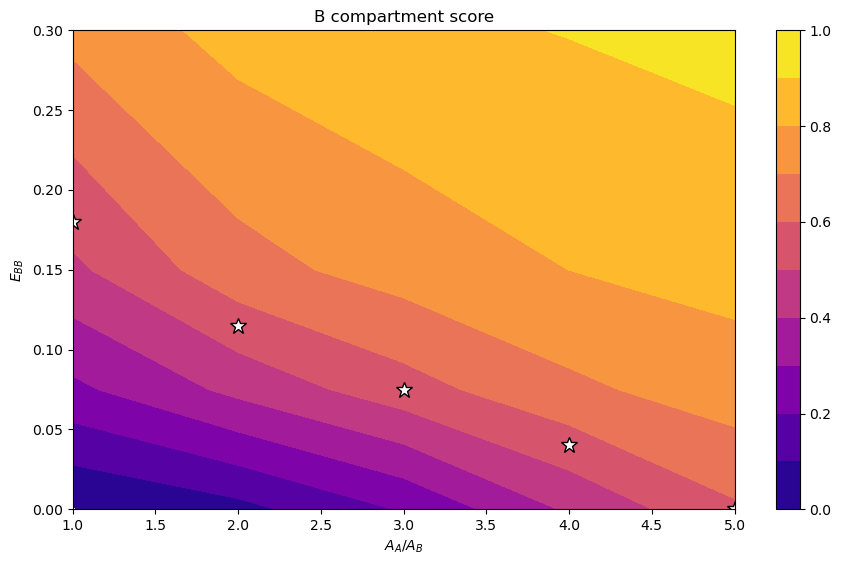

In [38]:
# create dataframe for contour plot
#new_df = compute_comp_score_all_data(datapath=Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/contact_maps/{chromo}'))

# plot contour maps
new_df = pd.read_csv(Path(f'/home/gridsan/lchan/git-remotes/polychrom_analysis/data/comp_scores/cs1_{chromo}_200-1000.csv'))
start_i_list = list(range(0, 1090, 11))
plot_contour_map(new_df, blocks = start_i_list[-1])
select_act = [1, 2, 3, 4, 5]
select_e0 = [0.18, 0.115, 0.075, 0.04, 0]
select_contour_param(new_df, select_act, select_e0, blocks=start_i_list[-1])

In [50]:
acts = [2]
E0s = [0.3]
plot_diagonal_diffs(acts[0], E0s[0], chromo, compartment = 'ab', normalize=True) # empty slice. fix intervals first